In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1232)
np.set_printoptions(formatter={'all':lambda x: '%.3f' % x})

In [2]:
from scipy.optimize import minimize
from scipy.stats import bernoulli, binom,uniform
from scipy.special import comb
from scipy.stats import binom, bernoulli

In [3]:
from keras.datasets import mnist
from sklearn.utils import shuffle
# np.set_printoptions(precision=15)

In [11]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = np.where(train_X>0.5,1,0)
# train_X = (train_X/128).astype('int')

In [12]:
n = 600
m = n *3
sz = 28

tol = 1e-15
max_iter = 100
np.random.seed(1232)
initWts = np.random.uniform(.25,.75,3)
tot = np.sum(initWts)
initWts = initWts/tot
phi = initWts

elbo_old = -1000000.0

x = np.array([train_X[np.where(train_y==2)[0][0:n],:,:],
                train_X[np.where(train_y==9)[0][0:n],:,:],
                train_X[np.where(train_y==3)[0][0:n],:,:]])
x = x.reshape(m,sz*sz,order='C')
x = shuffle(x)

# uni_model = uniform(loc=0.25,scale=0.5)
# thetas = np.array([uni_model.rvs(size=sz*sz),
#                    uni_model.rvs(size=sz*sz),
#                    uni_model.rvs(size=sz*sz)])
# dummy = np.sum(thetas,axis=1)
# thetas = thetas/dummy[:,np.newaxis]

initMeans = np.full((3, sz*sz), 1.0/3)
thetas = initMeans


In [16]:
for i in range(max_iter):

    mb_1 =  (thetas[0,:] ** x) * ((1-thetas[0,:])**(1-x))
    mb_2 =  (thetas[1,:] ** x) * ((1-thetas[1,:])**(1-x))
    mb_3 =  (thetas[2,:] ** x) * ((1-thetas[2,:])**(1-x))

    p_1 = np.prod(mb_1,axis=1) * phi[0]
    p_2 = np.prod(mb_2,axis=1) * phi[1]
    p_3 = np.prod(mb_3,axis=1) * phi[2]

    # p_1 = p_1.clip(min=1e-50)
    # p_2 = p_2.clip(min=1e-50)
    # p_3 = p_3.clip(min=1e-50)
    # p_1 = np.sum(p_1,axis=1)
    # p_2 = np.sum(p_2,axis=1)
    # p_3 = np.sum(p_3,axis=1)


    # p_1[np.isnan(p_1)]=-100
    # p_2[np.isnan(p_2)]=-100
    # p_3[np.isnan(p_3)]=-100

    # denom = np.exp(p_1) + np.exp(p_2) + np.exp(p_3)

    # w_1 = 1/(1+ np.exp(p_2-p_1) + np.exp(p_3-p_1))
    # w_2 = 1/(1+ np.exp(p_1-p_2) + np.exp(p_3-p_2))
    # w_3 = 1/(1+ np.exp(p_2-p_3) + np.exp(p_1-p_3))
    # w_1 = np.exp(p_1)/denom
    # w_2 = np.exp(p_2)/denom
    # w_3 = np.exp(p_3)/denom

    w_1 = p_1/(p_1+p_2+p_3)
    w_2 = p_2/(p_1+p_2+p_3)
    w_3 = p_3/(p_1+p_2+p_3)


    # elbo = np.sum(w_1 * p_1 + w_2 * p_2 + w_3 * p_3)


    mb_1 = mb_1.clip(min=1e-50)
    mb_2 = mb_2.clip(min=1e-50)
    mb_3 = mb_3.clip(min=1e-50)

    ll_1 = np.sum(np.log(mb_1),axis=1) + np.log(phi[0])
    ll_2 = np.sum(np.log(mb_2),axis=1) + np.log(phi[1])
    ll_3 = np.sum(np.log(mb_3),axis=1) + np.log(phi[2])


    elbo = np.sum(w_1 * ll_1 + w_2 * ll_2 + w_3 * ll_3)


    # thetas[0,:] = np.sum(w_1[:,np.newaxis] * x,axis=0)/np.sum(w_1 ,axis=0) + 0.0001
    # thetas[1,:] = np.sum(w_2[:,np.newaxis] * x,axis=0)/np.sum(w_2 ,axis=0) + 0.0001
    # thetas[2,:] = np.sum(w_3[:,np.newaxis] * x,axis=0)/np.sum(w_3,axis=0) + 0.0001

    thetas[0,:] = np.sum(w_1[:,np.newaxis]*x,axis=0) / np.sum(w_1)
    thetas[1,:] = np.sum(w_2[:,np.newaxis]*x,axis=0) / np.sum(w_2)
    thetas[2,:] = np.sum(w_3[:,np.newaxis]*x,axis=0) / np.sum(w_3)

    phi[0] = np.sum(w_1)/m
    phi[1] = np.sum(w_2)/m
    phi[2] = np.sum(w_3)/m
    
    print(f"Iteration: {i}")
    print('Phi is:',phi)
    # print("thetas[0] is:",thetas[0,0:10])
    print(f"ELBO is: {elbo}")
    diff = np.absolute(elbo-elbo_old,dtype='float64')
    if diff < tol:
        break
    else:
        print(np.abs(elbo-elbo_old))
        elbo_old = elbo

Iteration: 0
Phi is: [0.355 0.370 0.275]
ELBO is: -423892.26258269604
1.1641532182693481e-09
Iteration: 1
Phi is: [0.355 0.370 0.275]
ELBO is: -423892.2625800121
2.683955244719982e-06
Iteration: 2
Phi is: [0.355 0.370 0.275]
ELBO is: -423892.2564552307
0.006124781386461109
Iteration: 3
Phi is: [0.354 0.371 0.276]
ELBO is: -423878.06138560415
14.195069626555778
Iteration: 4
Phi is: [0.098 0.431 0.471]
ELBO is: -416211.54897289915
7666.512412704993
Iteration: 5
Phi is: [0.254 0.356 0.390]
ELBO is: -372815.79132394935
43395.7576489498
Iteration: 6
Phi is: [0.286 0.351 0.364]
ELBO is: -365001.5442629807
7814.247060968657
Iteration: 7
Phi is: [0.303 0.351 0.346]
ELBO is: -363490.74940183706
1510.7948611436295
Iteration: 8
Phi is: [0.312 0.353 0.335]
ELBO is: -362827.0660953476
663.683306489489
Iteration: 9
Phi is: [0.318 0.354 0.328]
ELBO is: -362349.8781439284
477.18795141915325
Iteration: 10
Phi is: [0.323 0.354 0.323]
ELBO is: -362046.1769060652
303.70123786322074
Iteration: 11
Phi is: [

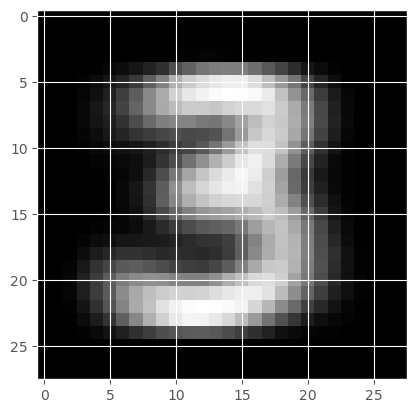

In [19]:
test = thetas.reshape(3,28,28)
plt.imshow(test[0,:],cmap=plt.get_cmap('gray'))

In [ ]:

def bernoulli(data, means):
    '''To compute the probability of x for each bernouli distribution
    data = N X D matrix
    means = K X D matrix
    prob (result) = N X K matrix 
    '''
    N = len(data)
    K = len(means)
    #compute prob(x/mean)
    # prob[i, k] for ith data point, and kth cluster/mixture distribution
    prob = np.zeros((N, K))
    
    for i in range(N):
        for k in range(K):
            prob[i,k] = np.prod((means[k]**data[i])*((1-means[k])**(1-data[i])))
    
    return prob

def respBernoulli(data, weights, means):
    '''To compute responsibilities, or posterior probability p(z/x)
    data = N X D matrix
    weights = K dimensional vector
    means = K X D matrix
    prob or resp (result) = N X K matrix 
    '''
    #step 1
    # calculate the p(x/means)
    prob = bernoulli(data, means)
    
    #step 2
    # calculate the numerator of the resp.s
    prob = prob*weights
    #step 3
    # calcualte the denominator of the resp.s
    row_sums = prob.sum(axis=1)[:, np.newaxis]
    
    # step 4
    # calculate the resp.s
    try:
        prob = prob/row_sums
        # print("prob is:",prob[0:10,0])

        return prob
    except ZeroDivisionError:
        print("Division by zero occured in reponsibility calculations!")

def bernoulliMStep(data, resp):
    '''Re-estimate the parameters using the current responsibilities
    data = N X D matrix
    resp = N X K matrix
    return revised weights (K vector) and means (K X D matrix)
    '''
    N = len(data)
    D = len(data[0])
    K = len(resp[0])
    
    Nk = np.sum(resp, axis=0)
    mus = np.empty((K,D))
    
    for k in range(K):
            mus[k] = np.sum(resp[:,k][:,np.newaxis]*data,axis=0) #sum is over N data points
            try:
                mus[k] = mus[k]/Nk[k]   
            except ZeroDivisionError:
                print("Division by zero occured in Mixture of Bernoulli Dist M-Step!")
                break           
    
    return (Nk/N, mus)

def llBernoulli(data, weights, means):
    '''To compute expectation of the loglikelihood of Mixture of Beroullie distributions
    Since computing E(LL) requires computing responsibilities, this function does a double-duty
    to return responsibilities too
    '''
    N = len(data)
    K = len(means)
    
    resp = respBernoulli(data, weights, means)
    
    ll = 0
    for i in range(N):
        # sumK = 0
        for k in range(K):
            try:
                temp1 = ((means[k]**data[i])*((1-means[k])**(1-data[i])))
                temp1 = np.log(temp1.clip(min=1e-50))
                
            except:
                print("Problem computing log(probability)")
            ll += resp[i, k]*(np.log(weights[k])+np.sum(temp1))
        # ll += sumK
    print(ll.dtype)
    return (ll, resp)

def mixOfBernoulliEM(data, init_weights, init_means, maxiters=1000, relgap=1e-4, verbose=False):
    '''EM algo fo Mixture of Bernoulli Distributions'''
    N = len(data)
    D = len(data[0])
    K = len(init_means)
    
    #initalize
    weights = init_weights[:]
    means = init_means[:]
    ll, resp = llBernoulli(data, weights, means)
    ll_old = ll
    
    for i in range(maxiters):
        if verbose and (i % 1 ==0):
            print("iteration {}:".format(i))
            print("   {}:".format(weights))
            print("   {:.6}".format(ll))
            
        #E Step: calculate resps
        #Skip, rolled into log likelihood calc
        #For 0th step, done as part of initialization
            
        #M Step
        weights, means = bernoulliMStep(data, resp)
        # print("means is:",means[0,0:10])
        #convergence check
        ll, resp = llBernoulli(data, weights, means)
        if np.abs(ll-ll_old)<relgap:
            print("Relative gap:{:.8} at iternations {}".format(ll-ll_old, i))
            break
        else:
            print(np.abs(ll-ll_old))
            ll_old = ll
            
    return (weights, means)


from sklearn.utils import shuffle

def experiments(digits, K, N, iters=50):
    '''
    Picks N random points of the selected 'digits' from MNIST data set and
    fits a model using Mixture of Bernoulli distributions.
    And returns the weights and means.
    '''
    
    expData = x
    
    D = len(expData[0])
    np.random.seed(1232)

    initWts = np.random.uniform(.25,.75,K)
    tot = np.sum(initWts)
    initWts = initWts/tot
    print("initWts are :",initWts)
    # initWts = [0.33,0.33,0.33]
    
    #initMeans = np.random.rand(10,D)
    initMeans = np.full((K, D), 1.0/K)

    return mixOfBernoulliEM(expData, initWts, initMeans, maxiters=iters, relgap=1e-15,verbose=True)

In [ ]:
finWeights, finMeans = experiments(['2','3','9'], 3, 1000)


In [ ]:
test = finMeans.reshape(3,28,28)
plt.imshow(test[2,:],cmap=plt.get_cmap('gray'))